In [1]:
import torch
import matplotlib.pyplot as plt
import cv2
import joblib
import quaternion as q
import numpy as np
from src.models.autoencoder.autoenc import Embedder
import torch.nn.functional as F
import imageio
from IPython.display import clear_output, HTML, display
import src.utils.pose_utils as pu
import torchvision.transforms.functional as TF
from einops import rearrange

## Load Models
- The noise models are from [Active Neural SLAM](https://github.com/devendrachaplot/Neural-SLAM)

In [2]:
device = 'cuda'
embedder = Embedder(pretrained_ckpt='pretrained/autoenc_large.ckpt',
                   img_res=128, w_size=128, coordinate_scale=32, w_ch=32, nerf_res=128, voxel_res=128)
embedder = embedder.to(device)#.eval()

import pickle
noise_dir = 'src/noise_models/'
sensor_noise_front = pickle.load(open(noise_dir + "sensor_noise_fwd.pkl", "rb"))
sensor_noise_right = pickle.load(open(noise_dir + "sensor_noise_right.pkl", "rb"))
sensor_noise_left = pickle.load(open(noise_dir + "sensor_noise_left.pkl", "rb"))

/home/ad01493624/codes/venv_rnr/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22.2.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Set up Habitat Simulator

In [3]:
import os
os.environ['GLOG_minloglevel'] = "3"
os.environ['MAGNUM_LOG'] = "quiet"
os.environ['HABITAT_SIM_LOG'] = "quiet"
import habitat
from habitat import get_config
from habitat.sims import make_sim

config = get_config()
cfg = config
cfg.defrost()
habitat_api_path = os.path.join(os.path.dirname(habitat.__file__), '../')
cfg.DATASET.SCENES_DIR = os.path.join(habitat_api_path, cfg.DATASET.SCENES_DIR)
cfg.DATASET.DATA_PATH = os.path.join(habitat_api_path, cfg.DATASET.DATA_PATH.replace("habitat-test-scenes","gibson"))
cfg.SIMULATOR.SCENE_DATASET = 'data/scene_datasets/mp3d.scene_dataset_config.json'
cfg.SIMULATOR.SCENE_DATASET = os.path.join(habitat_api_path, cfg.SIMULATOR.SCENE_DATASET)
cfg.DATASET.TYPE = "PointNav-v1"
cfg.SIMULATOR.RGB_SENSOR.HEIGHT = 128
cfg.SIMULATOR.RGB_SENSOR.WIDTH = 128
cfg.SIMULATOR.DEPTH_SENSOR.HEIGHT = 128
cfg.SIMULATOR.DEPTH_SENSOR.WIDTH = 128
cfg.TASK.SENSORS = cfg.SIMULATOR.AGENT_0.SENSORS = ['RGB_SENSOR', 'DEPTH_SENSOR']
cfg.freeze()

from habitat.datasets import make_dataset
dataset = make_dataset('PointNav-v1')
cfg.defrost()
cfg.DATASET.SPLIT = 'val'
cfg.freeze()
val_scenes = dataset.get_scenes_to_load(cfg.DATASET)
all_scenes =  val_scenes
print(f'Total {len(all_scenes)} scenes found')

2023-06-09 17:42:01,638 Initializing dataset PointNav-v1


Total 14 scenes found


In [5]:
scene = np.random.choice(all_scenes)
print(scene)

Cantwell


In [6]:
try: sim.close()
except: pass
cfg.defrost()
cfg.SIMULATOR.SCENE = os.path.join(cfg.DATASET.SCENES_DIR,'gibson_habitat/{}.glb'.format(scene))
cfg.freeze()
past_room = scene
sim = make_sim(id_sim=cfg.SIMULATOR.TYPE, config=cfg.SIMULATOR)

2023-06-09 17:42:05,105 initializing sim Sim-v0


In [7]:
MAX_TIME = 1000
VIS_RES = 256
NUM_SAMPLE_PIXEL = 200
OPT_LR = 0.001
NUM_OPT = 10

In [8]:
# These two functions are from NICE-SLAM (https://github.com/cvg/nice-slam/blob/master/src/common.py)
def quad2rotation(quad):
    bs = quad.shape[0]
    qr, qi, qj, qk = quad[:, 0], quad[:, 1], quad[:, 2], quad[:, 3]
    two_s = 2.0 / (quad * quad).sum(-1)
    rot_mat = torch.zeros(bs, 3, 3).to(quad.get_device())
    rot_mat[:, 0, 0] = 1 - two_s * (qj ** 2 + qk ** 2)
    rot_mat[:, 0, 1] = two_s * (qi * qj - qk * qr)
    rot_mat[:, 0, 2] = two_s * (qi * qk + qj * qr)
    rot_mat[:, 1, 0] = two_s * (qi * qj + qk * qr)
    rot_mat[:, 1, 1] = 1 - two_s * (qi ** 2 + qk ** 2)
    rot_mat[:, 1, 2] = two_s * (qj * qk - qi * qr)
    rot_mat[:, 2, 0] = two_s * (qi * qk - qj * qr)
    rot_mat[:, 2, 1] = two_s * (qj * qk + qi * qr)
    rot_mat[:, 2, 2] = 1 - two_s * (qi ** 2 + qj ** 2)
    return rot_mat

def get_camera_from_tensor(inputs):
    N = len(inputs.shape)
    if N == 1:
        inputs = inputs.unsqueeze(0)
    quad, T = inputs[:, :4], inputs[:, 4:]
    R = quad2rotation(quad)
    RT = torch.cat([R, T[:, :, None]], 2)
    RT = torch.cat((RT, torch.tensor((0,0,0,1)).to(RT.device).view(1, 1,4)),1)
    if N == 1:
        RT = RT[0]
    return RT

####
## Visualization code
def visualize_traj(gt_locs, pred_locs, bias_locs):
    all_locs = np.concatenate([np.array(gt_locs),np.array(pred_locs),np.array(bias_locs)])
    x_min, x_max = all_locs[:,0].min(), all_locs[:,0].max()
    y_min, y_max = all_locs[:,1].min(), all_locs[:,1].max()
    
    x_min, x_max = x_min - 1.0, x_max + 1.0
    y_min, y_max = y_min - 1.0, y_max + 1.0
    
    norm_gt_locs = np.array(gt_locs)
    norm_gt_locs[:,0] = (norm_gt_locs[:,0]-x_min)/(x_max - x_min + 1e-9)
    norm_gt_locs[:,1] = (norm_gt_locs[:,1]-y_min)/(y_max - y_min + 1e-9)
    
    norm_pred_locs = np.array(pred_locs)
    norm_pred_locs[:,0] = (norm_pred_locs[:,0]-x_min)/(x_max - x_min + 1e-9)
    norm_pred_locs[:,1] = (norm_pred_locs[:,1]-y_min)/(y_max - y_min + 1e-9)
    
    norm_bias_locs = np.array(bias_locs)
    norm_bias_locs[:,0] = (norm_bias_locs[:,0]-x_min)/(x_max - x_min + 1e-9)
    norm_bias_locs[:,1] = (norm_bias_locs[:,1]-y_min)/(y_max - y_min + 1e-9)
    
    hw_gt_locs = ((norm_gt_locs * 2 - 1) * (VIS_RES/2) + VIS_RES/2).astype(np.uint8)
    hw_pred_locs = ((norm_pred_locs * 2 - 1) * (VIS_RES/2) + VIS_RES/2).astype(np.uint8)
    hw_bias_locs = ((norm_bias_locs * 2 - 1) * (VIS_RES/2) + VIS_RES/2).astype(np.uint8)
    
    hw_gt_locs = np.linspace(hw_gt_locs, np.roll(hw_gt_locs,-1, axis=0)).astype(np.uint8)
    hw_pred_locs = np.linspace(hw_pred_locs, np.roll(hw_pred_locs,-1, axis=0)).astype(np.uint8)
    hw_bias_locs = np.linspace(hw_bias_locs, np.roll(hw_bias_locs,-1, axis=0)).astype(np.uint8)
    vis_traj = np.full((VIS_RES, VIS_RES, 3), 255, dtype=np.uint8)
    for t in range(len(gt_locs)-1):
        for ii in range(-2,3):
            for jj in range(-2,3):
                old = min(len(gt_locs) - t, 100)/100
                vis_traj[hw_gt_locs[:,t,0]+ii, hw_gt_locs[:,t,1]+jj] = [int(255*old),int(255*old),int(255*old)]
                vis_traj[hw_bias_locs[:,t,0]+ii, hw_bias_locs[:,t,1]+jj] = [int(255*old),255,int(255*old)]
                vis_traj[hw_pred_locs[:,t,0]+ii, hw_pred_locs[:,t,1]+jj] = [255,int(255*old),int(255*old)]
    return vis_traj

## Pose Optimization

In [ ]:
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower

# Sample an episode
follower = ShortestPathFollower(sim, 0.5, return_one_hot=False)

start_position = sim.sample_navigable_point()
start_rotation = q.from_euler_angles([0., np.random.rand() * 2 * np.pi, 0.])


sim.set_agent_state(start_position, start_rotation)
done = False
while True:
    goal_point = sim.sample_navigable_point()
    if abs(goal_point[1]-start_position[1]) > 0.5: continue
    break
    

# Setup Initial RNR-Map
K = torch.eye(3)
K[0,0] = (embedder.img_res/2.) / np.tan(np.deg2rad(90.0) / 2)
K[1,1] = -(embedder.img_res/2.) / np.tan(np.deg2rad(90.0) / 2)
K = K.unsqueeze(0).to(device)

orig_Rt = np.eye(4)
orig_Rt[:3,3] = start_position
orig_Rt[:3,:3] = q.as_rotation_matrix(start_rotation)
orig_Rt = torch.from_numpy(np.linalg.inv(orig_Rt)).float()

w, w_mask = None, None

# Start an episode
start_loc = curr_bias_loc = curr_gt_loc = curr_loc = pu.get_sim_location(start_position,start_rotation)

action = None
time_t = 0

gt_locs, bias_locs, adjust_locs = [], [], []
vis_traj = np.full((VIS_RES, VIS_RES, 3),255, dtype=np.uint8)
images = []
while not done:
    state = sim.get_agent_state()
    obs = sim.get_observations_at(state.position, state.rotation)
    
    new_gt_loc = pu.get_sim_location(state.position, state.rotation) 
    dx_gt, dy_gt, do_gt = pu.get_rel_pose_change(new_gt_loc, curr_gt_loc) # gt odometry
    
    if action is not None:
        # Add noise to odometry
        if action == 1:  ## Forward
            dx, dy, do = sensor_noise_front.sample()[0][0]
        elif action == 2:  ## Left
            dx, dy, do = sensor_noise_left.sample()[0][0]
        elif action == 3:  ## Right
            dx, dy, do = sensor_noise_right.sample()[0][0]
        do = np.deg2rad(do)
        dp_gt = (dx_gt, dy_gt, do_gt)
        curr_gt_loc = pu.get_new_pose(curr_gt_loc, dp_gt) # gt position
        dp = (dx_gt + dx, dy_gt + dy, do_gt + do)
        curr_loc = pu.get_new_pose(curr_loc, dp) # predicted position
        curr_bias_loc = pu.get_new_pose(curr_bias_loc, dp) # predicted poistion without pose adjustment
        
    rgb_t = torch.from_numpy(obs['rgb']/255.).unsqueeze(0).permute(0,3,1,2).to(device)
    depth_t = torch.from_numpy(obs['depth']).unsqueeze(0).permute(0,3,1,2).to(device)
    if time_t > 0:
        # Optimize pose
        with torch.enable_grad():
            x = torch.tensor(-curr_loc[1]).float().cuda()
            y = torch.tensor(-curr_loc[0]).float().cuda()
            z = torch.tensor(start_position[1]).float().cuda()
            a = torch.tensor(curr_loc[2]).float().cuda()
            x.requires_grad = y.requires_grad = a.requires_grad = True

            K.requires_grad = False
            w = w.detach()
            w.requires_grad = False
            optim = torch.optim.Adam([x, y, a], lr=OPT_LR)
            
            quad = torch.stack([torch.cos(a/2), torch.tensor(0.).cuda(), torch.sin(a/2), torch.tensor(0.).cuda()])
            trans = torch.stack([x,z,y])
            inputs = torch.cat((quad, trans))
            Rt = get_camera_from_tensor(inputs)
            Rt = Rt.inverse() @ orig_Rt.inverse().cuda()

            
            min_loss = 100
            min_inputs = inputs.clone()
            min_Rt = Rt.clone()
            for i in range(NUM_OPT):
                quad = torch.stack([torch.cos(a / 2), torch.tensor(0.).cuda(), torch.sin(a / 2), torch.tensor(0.).cuda()])
                trans = torch.stack([x, z, y])
                inputs = torch.cat((quad, trans))
                Rt = get_camera_from_tensor(inputs)
                Rt = Rt.inverse() @ orig_Rt.inverse().cuda()
                rgb, depth, indices = embedder.sample_generate(w,{"Rt": Rt.unsqueeze(0).unsqueeze(1).float(),
                                                                'K': K.unsqueeze(0).cuda()},
                                                                  out_res=128, num_samples=NUM_SAMPLE_PIXEL)
                flattened_rgb_t = rearrange(rgb_t, 'b c h w -> b (h w) c')[0]
                rgb_loss = F.l1_loss(rgb[0], flattened_rgb_t[indices])
                depth_loss = F.l1_loss(depth/10.0, depth_t.view(rgb_t.shape[0], -1)[:, indices])
                loss = rgb_loss + depth_loss
                if min_loss > loss:
                    min_Rt = Rt.clone()
                    min_loss = loss
                    min_inputs = inputs.clone()
                optim.zero_grad()
                loss.backward()
                #grad = torch.nn.utils.clip_grad_norm_(Rt, 0.1)
                optim.step()  

        Rt_t = min_Rt.detach()
        world_position = min_inputs[-3:].detach().cpu().numpy()
        world_rotation = q.from_float_array(min_inputs[:4].detach().cpu().numpy())
        curr_loc = pu.get_sim_location(world_position, world_rotation)
    else:
        Rt_t = torch.eye(4).to(device)

    adjust_locs.append(curr_loc)
    gt_locs.append(curr_gt_loc)
    bias_locs.append(curr_bias_loc)
    
    vis_traj = visualize_traj(gt_locs, adjust_locs, bias_locs)
    
    Rt_t = Rt_t.unsqueeze(0)

    with torch.no_grad():
        output = embedder.calculate_mask_func(depth_t*10.0, Rt_t, K)
        sorted_indices, seq_unique_list, seq_unique_counts, _ = output
        input_dict = {'rgb': rgb_t.unsqueeze(1), 
                      'depth': depth_t.unsqueeze(1), 
                    'sorted_indices': sorted_indices.unsqueeze(1), 
                    'seq_unique_counts': seq_unique_counts.unsqueeze(1),
                      'seq_unique_list': seq_unique_list.unsqueeze(1)}
        w, w_mask = embedder.embed_obs(input_dict, past_w=w, past_w_num_mask=w_mask)
    
        w_im = w.mean(0).mean(0).detach().cpu().numpy()
        w_im = ((w_im - w_im.min())/(w_im.max()-w_im.min()) * 255).astype(np.uint8)
        w_im = cv2.applyColorMap(w_im, cv2.COLORMAP_VIRIDIS)[:,:,::-1]
    
    view_im = np.concatenate([vis_traj, cv2.resize(obs['rgb'], (VIS_RES,VIS_RES)), 
                                       cv2.resize(w_im, (VIS_RES, VIS_RES))],1)
    images.append(view_im)
    cv2.imshow("View", view_im[:,:,::-1])
    key = cv2.waitKey(1)
    if key == ord("q"): break
    
    # robot action
    action = follower.get_next_action(goal_point)
    if time_t > MAX_TIME: break
    if action is None or action == 0:
        while True:
            goal_point = sim.sample_navigable_point()
            if abs(goal_point[1]-start_position[1]) > 0.5: continue
            break
        action = follower.get_next_action(goal_point)
    sim.step(action)
    time_t += 1

In [15]:
imageio.mimwrite("demo/camera-tracking.gif", small_images, fps=10)
display(HTML('<img src={}>'.format("demo/camera-tracking.gif")))

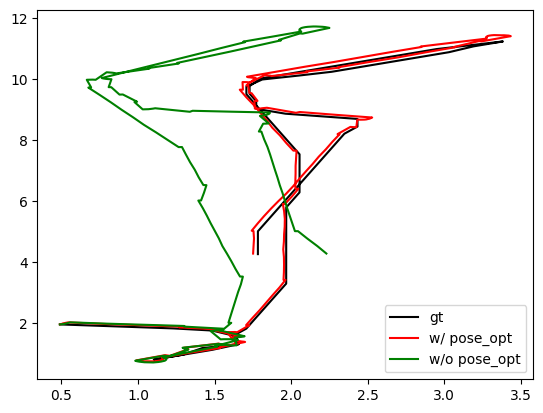

In [10]:
T = len(gt_locs)
plt.plot(np.array(gt_locs)[:T,0],np.array(gt_locs)[:T,1], label='gt', color='black')
plt.plot(np.array(adjust_locs)[:T,0],np.array(adjust_locs)[:T,1],label='w/ pose_opt', color='red')
plt.plot(np.array(bias_locs)[:T,0],np.array(bias_locs)[:T,1], label='w/o pose_opt', color='green')
plt.legend()
plt.show()